## UNET Model for the CAMUS dataset using the MONAI platform

### Purpose

This notebook will explore the models that will do a segmentation of the left ventricle. Here I will use the CAMUS dataset with the ES and ED phases with their corresponding ground truth masks as my input and output for the model. 

In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Import all the necessary packages.

In [3]:
import monai
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import medpy
import PIL
import os
import shutil
import tempfile
from pathlib import Path
import pprint

/home/jyoti/Projects/Python/topeka-chapter-ejection-fraction/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from monai.config import print_config
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.2
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/jyoti/Projects/Python/topeka-chapter-ejection-fraction/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Set the base directory where the data resides. 
If using Google Drive set here

In [5]:
%env DATA_DIRECTORY = /content/drive/MyDrive/LVEF

env: DATA_DIRECTORY=/content/drive/MyDrive/LVEF


If using a local drive, set directory below

In [6]:

%env DATA_DIRECTORY =  /opt/Data

env: DATA_DIRECTORY=/opt/Data


In [7]:
## if environment variable is not set , get a temp directory. 
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

/opt/Data


In [8]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

Download and extract the CAMUS dataset. This step is not needed if the data was downloaded and unzipped.

In [9]:
pp = pprint.PrettyPrinter()
from monai.utils import set_determinism
set_determinism(seed=0)
from monai.apps import download_and_extract, extractall

In [10]:
CAMUS_ORIGINAL_DATA_DIR = 'CAMUS/original_data/data'
CAMUS_DATA_DIR = 'New_CAMUS_png/CAMUS'

In [11]:
# May not work on WIndows
#resource = "https://scholar.cu.edu.eg/Dataset_BUSI.zip"
compressed_file = ROOT_DIR.joinpath("CAMUS.zip")
DATA_DIR = ROOT_DIR.joinpath(CAMUS_DATA_DIR)
if not os.path.exists(DATA_DIR):
    extractall(compressed_file, ROOT_DIR)
checkPathExists(DATA_DIR)

Path /opt/Data/New_CAMUS_png/CAMUS accessible


Organize the file names used for training and testing into Python lists for easy access when needed.

In [12]:
TRAINING_DATA_DIR = DATA_DIR.joinpath('Training')
TESTING_DATA_DIR = DATA_DIR.joinpath('Testing')
TWO_CHANNEL = '2CH'
FOUR_CHANNEL = '4CH'
PHASE_NAMES = ['ED', 'ES']

In [13]:
### Set the file list as
#[ 
#   ED [(input_file, mask_file), (input_file, mask_file), ....]
#   ES [(input_file, mask_file), (input_file, mask_file), ....]
#]
def data_directories(data_path, class_names, chamber_view):
    num_phases = len(class_names)
    patient_list = [x for x in data_path.iterdir() if x.is_dir()]

    image_files_list = [
        [
            (p, Path(str(p).replace(f"{class_names[i]}", f"{class_names[i]}_gt")))
            for x in patient_list
            for j, p in enumerate(x.glob(f"**/{chamber_view}*{class_names[i]}.png"))
        ]
        for i in range(num_phases)
    ]
    return image_files_list

In [14]:
training_2chamber_image_files = data_directories(TRAINING_DATA_DIR, PHASE_NAMES, TWO_CHANNEL)
training_4chamber_image_files = data_directories(TRAINING_DATA_DIR, PHASE_NAMES, FOUR_CHANNEL)
testing_2chamber_image_files = data_directories(TESTING_DATA_DIR, PHASE_NAMES, TWO_CHANNEL)
testing_4chamber_image_files = data_directories(TESTING_DATA_DIR, PHASE_NAMES, FOUR_CHANNEL)
#pp.pprint(training_2chamber_image_files[1])

In [15]:
def data_description(image_files_list):
    num_total = len(image_files_list[0])
    image_width, image_height = PIL.Image.open(image_files_list[0][0][0]).size
    print(f"Total Image Count: {num_total}")
    print(f"Image Dimensions: {image_width} x {image_height}")

In [16]:
print(f"Two Chamber Training Data Count")
data_description(training_2chamber_image_files)
print("-------------")
print(f"Four Chamber Training Data Count")
data_description(training_4chamber_image_files)
print("-------------")
print(f"Two Chamber Testing Data Count")
data_description(testing_2chamber_image_files)
print("-------------")
print(f"Four Chamber Testing Data Count")
data_description(testing_4chamber_image_files)
print("-------------")

Two Chamber Training Data Count
Total Image Count: 400
Image Dimensions: 256 x 256
-------------
Four Chamber Training Data Count
Total Image Count: 400
Image Dimensions: 256 x 256
-------------
Two Chamber Testing Data Count
Total Image Count: 50
Image Dimensions: 256 x 256
-------------
Four Chamber Testing Data Count
Total Image Count: 50
Image Dimensions: 256 x 256
-------------


Lets load the information file as a pandas dataframe

In [17]:
TRAINING_2CH_INFO_DIR = TRAINING_DATA_DIR.joinpath('training_2ch_info')
TRAINING_4CH_INFO_DIR = TRAINING_DATA_DIR.joinpath('training_4ch_info')
TESTING_2CH_INFO_DIR = TESTING_DATA_DIR.joinpath('testing_2ch_info')
TESTING_4CH_INFO_DIR = TESTING_DATA_DIR.joinpath('testing_4ch_info')
checkPathExists(TRAINING_2CH_INFO_DIR)
checkPathExists(TRAINING_4CH_INFO_DIR)
checkPathExists(TESTING_2CH_INFO_DIR)
checkPathExists(TESTING_4CH_INFO_DIR)

Path /opt/Data/New_CAMUS_png/CAMUS/Training/training_2ch_info accessible
Path /opt/Data/New_CAMUS_png/CAMUS/Training/training_4ch_info accessible
Path /opt/Data/New_CAMUS_png/CAMUS/Testing/testing_2ch_info accessible
Path /opt/Data/New_CAMUS_png/CAMUS/Testing/testing_4ch_info accessible


In [24]:
def data_info_file(info_dir, chamber_view):
    info_df = pd.DataFrame()
    for file in info_dir.glob(f"**/*.cfg"):
        with open(file) as f: 
            data = f.readlines() 
            data = [x.rstrip('\n') for x in data]
            data = { f"{x.split(': ')[0]}_{chamber_view}": x.split(': ')[1] for x in data}
            data['id'] = str(file.name).split('_')[0]
            info_df = pd.concat([info_df, pd.DataFrame([data])])
    info_df = info_df.reset_index(drop=True)
    info_df = info_df.set_index('id')
    return info_df

In [144]:
training_2chamber_info_df = data_info_file(TRAINING_2CH_INFO_DIR, TWO_CHANNEL)
training_4chamber_info_df = data_info_file(TRAINING_4CH_INFO_DIR, FOUR_CHANNEL)
testing_2chamber_info_df = data_info_file(TESTING_2CH_INFO_DIR, TWO_CHANNEL)
testing_4chamber_info_df = data_info_file(TESTING_4CH_INFO_DIR, FOUR_CHANNEL)

In [145]:
training_2chamber_info_df.LVedv_2CH = training_2chamber_info_df.LVedv_2CH.astype('float32')
training_2chamber_info_df.LVesv_2CH = training_2chamber_info_df.LVedv_2CH.astype('float32')
training_2chamber_info_df.LVef_2CH = training_2chamber_info_df.LVef_2CH.astype('float32')

training_4chamber_info_df.LVedv_4CH = training_4chamber_info_df.LVedv_4CH.astype('float32')
training_4chamber_info_df.LVesv_4CH = training_4chamber_info_df.LVedv_4CH.astype('float32')
training_4chamber_info_df.LVef_4CH = training_4chamber_info_df.LVef_4CH.astype('float32')

testing_2chamber_info_df.LVedv_2CH = testing_2chamber_info_df.LVedv_2CH.astype('float32')
testing_2chamber_info_df.LVesv_2CH = testing_2chamber_info_df.LVedv_2CH.astype('float32')
testing_2chamber_info_df.LVef_2CH = testing_2chamber_info_df.LVef_2CH.astype('float32')

testing_4chamber_info_df.LVedv_4CH = testing_4chamber_info_df.LVedv_4CH.astype('float32')
testing_4chamber_info_df.LVesv_4CH = testing_4chamber_info_df.LVedv_4CH.astype('float32')
testing_4chamber_info_df.LVef_4CH = testing_4chamber_info_df.LVef_4CH.astype('float32')

In [228]:
## Save the files here for easy access later

### EDA for CAMUS dataset

Lets look at the characteristics of the CAMUS data

According to the American Heart Association:

    A left ventricle (LV) ejection fraction of about 50% to 70% is categorized as normal.
    A mildly reduced LV ejection fraction is usually between 41% and 49%.
    A reduced LV ejection fraction is usually 40% or less.

1. Distribute the Training data into normal, mild, and abnormal

In [146]:
def data_hfclass(df):
    lvef_class = []
    for i in df:
        if i >= 50:
            lvef_class.append('Normal')
        elif i > 40:
            lvef_class.append('Mild')
        else:
            lvef_class.append('Abnormal')
    lv_class = pd.Series(lvef_class, name='HFClass')
    lv_class = lv_class.astype('category')
    lv_class.index = df.index
    return lv_class

In [147]:
training_2chamber_info_df = pd.concat([training_2chamber_info_df, data_hfclass(training_2chamber_info_df.LVef_2CH)], axis=1)
training_4chamber_info_df = pd.concat([training_4chamber_info_df, data_hfclass(training_4chamber_info_df.LVef_4CH)], axis=1)
testing_2chamber_info_df = pd.concat([testing_2chamber_info_df, data_hfclass(testing_2chamber_info_df.LVef_2CH)], axis=1)
testing_4chamber_info_df = pd.concat([testing_4chamber_info_df, data_hfclass(testing_4chamber_info_df.LVef_4CH)], axis=1)

2. Visualize the training/testing data for 2 chamber and 4 chamber in terms of their Diagnostic classes

In [229]:
def generate_pie_plot(labels, title="Categories", ax = None):
    proportions = []
    sz = len(labels.unique())
    total = labels.value_counts().sum()
    for c in range(sz):
        prop = labels.value_counts()[c]
        print(f"Proportion of data in class {c} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=labels.unique(), autopct='%1.1f%%', colors = colors, textprops={'color':"gray"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='gray')

Proportion of data in class 0 is 274 : 60.89 %
Proportion of data in class 1 is 103 : 22.89 %
Proportion of data in class 2 is 73 : 16.22 %
Proportion of data in class 0 is 33 : 66.00 %
Proportion of data in class 1 is 10 : 20.00 %
Proportion of data in class 2 is 7 : 14.00 %
Proportion of data in class 0 is 274 : 60.89 %
Proportion of data in class 1 is 103 : 22.89 %
Proportion of data in class 2 is 73 : 16.22 %
Proportion of data in class 0 is 33 : 66.00 %
Proportion of data in class 1 is 10 : 20.00 %
Proportion of data in class 2 is 7 : 14.00 %


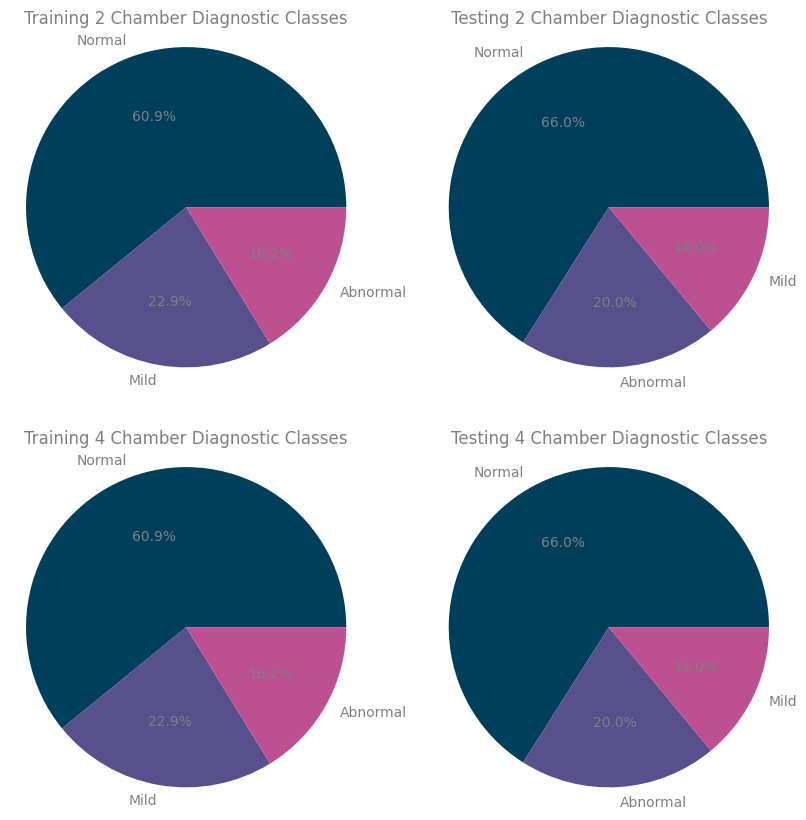

In [230]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
generate_pie_plot(training_2chamber_info_df.HFClass, 'Training 2 Chamber Diagnostic Classes', ax[0][0])
generate_pie_plot(testing_2chamber_info_df.HFClass, 'Testing 2 Chamber Diagnostic Classes', ax[0][1])
generate_pie_plot(training_4chamber_info_df.HFClass, 'Training 4 Chamber Diagnostic Classes', ax[1][0])
generate_pie_plot(testing_4chamber_info_df.HFClass, 'Testing 4 Chamber Diagnostic Classes', ax[1][1])

The training and testing data is similarly distributed based on its diagnostic class

3. Lets visualize the distribution of the diagnostic classes in terms of the age groups

In [232]:
training_2chamber_info_df.Age_2CH.min()
training_2chamber_info_df.Age_2CH.max()

'93'